In [1]:
%matplotlib inline
import pylab as pl
from astropy import units as u, constants, visualization
visualization.quantity_support()
pl.style.use('dark_background')

# Model Fitting & Measurement in practice

AST 4723

# Measurements

We can make several measurements from the spectra we've obtained:

1. The frequency of the line
2. The intensity of the line

# Line Profiles

So what is a "spectral line" anyway?

The HI spin-flip transition is a quantum process that produces a photon at a specific frequency, and it *always* produces a photon at that frequency - in the rest frame of the particle.  (exceptions to be discussed in a later lecture)

# Line Profiles - Doppler Shift

The "line profile" we observe is caused by *doppler shift* in the line center.

The Doppler formula (in the "radio convention" approximation) is:

$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{observed}}{\nu_{rest}} $$

# Line Profiles - Doppler Shift

What causes $\nu_{observed}$ to vary, then?

Often the most important process is *thermal broadening*.

Particles in a gas move according to the Maxwell-Boltzmann Distribution

# Maxwell-Boltzmann distribution

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Simulation_of_gas_for_relaxation_demonstration.gif/450px-Simulation_of_gas_for_relaxation_demonstration.gif" style="max-height: 600px">


# Line Profiles - Maxwell-Boltzmann Distribution

The Maxwell-Boltzmann velocity vector distribution tells you how fast a particle is moving along your line-of-sight.  

$$c_s = \sqrt{\frac{k_B T}{m}}$$

$k_B$ is Boltzmann's constant, $T$ is the gas temperature, and $m$ is the particle mass.  $c_s$ is the *speed of sound*, and is the width of the Boltzmann velocity distribution for an isothermal (single-temperature) gas. 

This gives a probability distribution:

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right] = \exp\left[\frac{-m v_{los}^2}{2 k_B T}\right]$$

# Line Profiles - Maxwell-Boltzmann Distribution

This is a Gaussian distribution, $f(x) \propto e^{-x^2}$:

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right]$$

It tells you how many particles are moving at each velocity.  For example...

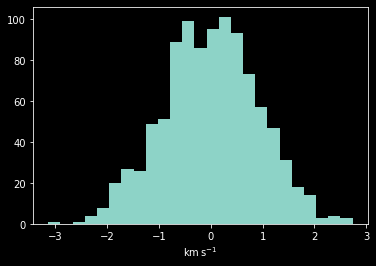

In [2]:
# Example: There are 1000 Hydrogen particles with T=100 K
temperature = 100*u.K
hydrogen_mass = 1*u.Da # a "Dalton" is the Atomic Mass Unit
soundspeed = ((constants.k_B * temperature / hydrogen_mass)**0.5).to(u.km/u.s)
# sample particle velocities from a "normal" (Gaussian) distribution
particle_velocities = np.random.randn(1000) * soundspeed
_=pl.hist(particle_velocities, bins=25)

# Line Profiles - Doppler Shift

A moving particle produces a photon at a different frequency as determined by the doppler formula:

$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{moving}}{\nu_{rest}} $$

gives

$$ \nu_{moving} = \nu_{rest} \left(1 - \frac{\Delta v}{c}\right) $$

# Line Profiles - Doppler Shift
The doppler formula combined with the Boltzmann distribution gives:
$$ \frac{\Delta v}{c} = \frac{\nu_{rest} - \nu_{moving}}{\nu_{rest}} =  \frac{\nu_{rest} - \nu_{los}}{\nu_{rest}} $$

$$p(v_{los}) = \exp\left[\frac{-v_{los}^2}{2 c_s^2}\right]$$



$$ p(\nu_{los}) =  \exp\left[\frac{-\left[c(\nu_{rest}-\nu_{los})/\nu_{rest}\right]^2}{2 c_s^2}\right] $$


# Line Profiles - Doppler Shift

This is the line profile produced by an isothermal gas:

$$ p(\nu_{los}) =  \exp\left[\frac{-\left[c (\nu_{rest}-\nu_{los})/( \nu_{rest})\right]^2}{2 c_s^2}\right] $$


# Line Profile - Measurement

Most line profiles are dominated by motion and end up with Gaussian profiles.  There are other physical effects, including *pressure broadening* and *natural width* (from the Heisenberg uncertainty principle) that we'll discuss later, but for now we assume all line emission is broadened by motion.

Given that starting assumption, we can measure physical properties of the gas from the line profile.

In [3]:
# a simulated line profile
nu_hi = 1420.405751 * u.MHz
bandwidth = 2.5 * u.MHz
frequency_axis = np.linspace(nu_hi - bandwidth/2, nu_hi + bandwidth/2, 2048)
# assume we're measuring something in Janskys
model_line_profile = np.exp(-(constants.c * (nu_hi - frequency_axis)/(nu_hi * soundspeed ))**2 / 2) * u.Jy

(1420.3, 1420.5)

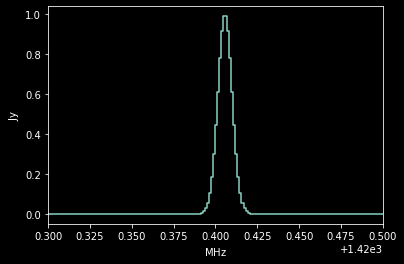

In [4]:
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.3,1420.5)

# Line Profile - Measurement

The *width* tells us about the *velocity distribution*, which can be used to infer the temperature (in some cases).

How do we measure the width?  A few possibilities exist:
1. Eyeball it
2. Use *moment analysis*
3. Fit a model function to the data

# Line Profile - Measurement

The eyeball method: A Gaussian distribution has a well-defined width.  

The full-width at half-maximum (FWHM) is related to the width $\sigma$ as:

$$ FWHM = \sqrt{8 \ln 2}~\sigma$$

The width of a thermally broadened line is $\sigma = c_s$, so if we can estimate how wide the line is "by eye", we can get a quick estimate of the sound speed and therefore the temperature.

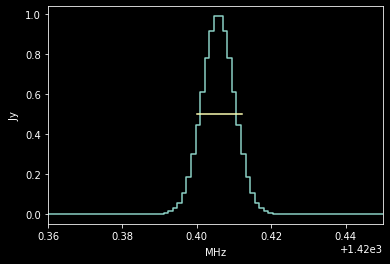

In [5]:
# drop a ruler onto the plot and measure the FWHM... you can get pretty close
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.plot([1420.4,1420.4122], [0.5,0.5])

# Line Profile - Measurement

Moment Analysis is the quickest, simplest approach. 

The *zero'th moment* is the integral of the distribution:

$$m_0 = \int p(\nu) d\nu$$


The first moment is the *centroid*:

$$m_1 = \frac{\int \nu p(\nu) d\nu}{\int p(\nu) d\nu}$$

The second *central* moment measures the width:

$$m_2 = \frac{\int (\nu - \nu_{center})^2 p(\nu) d \nu}{\int p(\nu) d\nu} $$

# Line Profile - Measurement

What does moment 0 mean?
$$m_0 = \int p(\nu) d\nu$$
In practice, we calculate this as 
$$ m_0 = \Sigma S_\nu \Delta \nu$$

$S_\nu$ is the recorded brightness value, and $\Delta \nu$ is the width of a channel.  This is the "total intensity" or "integrated intensity" and represents the total amount of light received from the line.  It will have units of "flux units" times "X-axis units"; for example, Jy Hz or K km/s.

In [6]:
delta_nu = frequency_axis[1] - frequency_axis[0]
moment0 = (model_line_profile * delta_nu).sum()
moment0

<Quantity 0.01082926 Jy MHz>

# Line Profile - Measurement

What does moment 1 mean?

$$m_1 = \frac{\int \nu p(\nu) d\nu}{\int p(\nu) d\nu}$$

In practice, we calculate this as 

$$m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0}$$

$m_1$ is the *weighted average* of the X-axis $\nu$.  It has the same units as $\nu$ - frequency.

In [7]:
moment1 = (frequency_axis * model_line_profile * delta_nu).sum() / moment0
moment1

<Quantity 1420.405751 MHz>

# Line Profile - Measurement

What does moment 2 mean?
$$m_2 = \frac{\int (\nu - \nu_{center})^2 p(\nu) d \nu}{\int p(\nu) d\nu} $$
In practice, we calculate this as 
$$m_2 = \frac{\Sigma \left(\nu - m_1\right)^2 S_\nu \Delta \nu}{m_0}$$
$m_2$ is the *intensity-weighted variance*.  It has units $[\nu]^2$.  Recall that *variance* is the square of the *standard deviation*.  The *Gaussian width* $\sigma=m_2^{1/2}$.

We subtract out $m_1$ from each frequency because we're calculating the variance around a central point.

In [8]:
moment2 = ( (frequency_axis - moment1)**2 * model_line_profile * delta_nu).sum() / moment0
sigma = moment2**0.5
moment2, sigma

(<Quantity 1.86645543e-05 MHz2>, <Quantity 0.00432025 MHz>)

# Line Profile Measurement - moments work

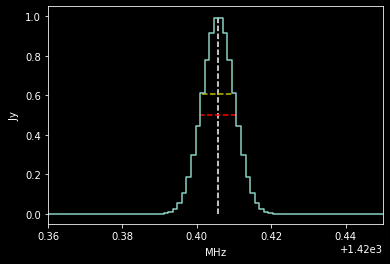

In [9]:
pl.plot(frequency_axis, model_line_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.vlines(moment1, 0*u.Jy, 1*u.Jy, color='w', linestyle='--')
# the Gaussian width is the half-width at exp(-1/2)
pl.hlines( np.exp(-0.5), moment1-sigma, moment1+sigma, color='y', linestyle='--')
pl.hlines( 0.5, moment1-sigma*2.35/2, moment1+sigma*2.35/2, color='r', linestyle='--')

# Line Profile Measurements - what about noise?

Even in the presence of noise, moment analysis is very effective - but it can go awry.

In [10]:
np.random.seed(0)
uncertainty = 0.1 * model_line_profile.unit
noisy_model_profile = model_line_profile + uncertainty * np.random.randn(model_line_profile.size)

(1420.33, 1420.48)

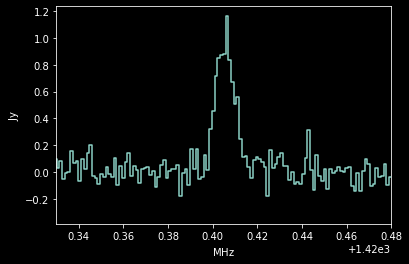

In [11]:
pl.plot(frequency_axis, noisy_model_profile, drawstyle='steps-mid')
pl.xlim(1420.33,1420.48)

In [12]:
noisy_moment0 = noisy_model_profile.sum() * delta_nu
noisy_moment1 = (frequency_axis * noisy_model_profile * delta_nu).sum() / noisy_moment0
noisy_moment2 = ( (frequency_axis - noisy_moment1)**2 * noisy_model_profile * delta_nu).sum() / noisy_moment0
noisy_sigma = noisy_moment2**0.5
noisy_moment0, noisy_moment1, noisy_moment2, noisy_sigma

/home/adam/repos/astropy/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Quantity 0.00707108 Jy MHz>,
 <Quantity 1420.86404663 MHz>,
 <Quantity -0.43715543 MHz2>,
 <Quantity nan MHz>)

What happened?  The centroid is wrong, and the noise won out over the signal.  If we re-measure over a subset... if we "crop" the spectrum.... we can get a reasonable answer again:

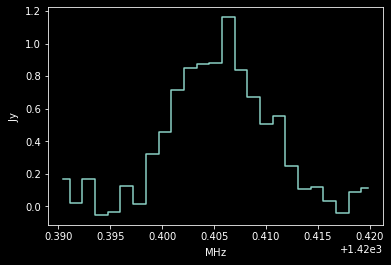

In [13]:
selection = ((frequency_axis > 1420.39 * u.MHz) &
             (frequency_axis < 1420.42*u.MHz))
pl.plot(frequency_axis[selection],
        noisy_model_profile[selection], drawstyle='steps-mid')

In [14]:
noisy_moment0 = noisy_model_profile[selection].sum() * delta_nu
noisy_moment1 = (frequency_axis[selection] * noisy_model_profile[selection] * delta_nu).sum() / noisy_moment0
noisy_moment2 = ( (frequency_axis[selection] - noisy_moment1)**2 * noisy_model_profile[selection] * delta_nu).sum() / noisy_moment0
noisy_sigma = noisy_moment2**0.5
noisy_moment0, noisy_moment1, noisy_moment2, noisy_sigma

(<Quantity 0.01088147 Jy MHz>,
 <Quantity 1420.40551509 MHz>,
 <Quantity 2.4993493e-05 MHz2>,
 <Quantity 0.00499935 MHz>)

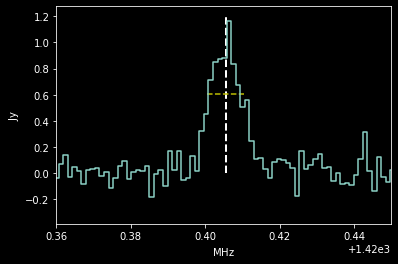

In [15]:
pl.plot(frequency_axis, noisy_model_profile, drawstyle='steps-mid')
pl.xlim(1420.36,1420.45)
pl.vlines(noisy_moment1, 0*u.Jy, 1.2*u.Jy, color='w', linestyle='--', linewidth=2)
# the Gaussian width is the half-width at exp(-1/2)
pl.hlines(np.exp(-0.5), noisy_moment1-noisy_sigma, noisy_moment1+noisy_sigma, color='y', linestyle='--')

# Moment Analysis - Physical inference

What do the various moments tell us about the thing we're looking at?

Moment 0 is the integrated intensity.  It's how much light we get.

Moment 1 is the line-of-sight velocity:

In [16]:
v_los_measured = (nu_hi - moment1) / nu_hi  * constants.c
noisy_v_los_measured = (nu_hi - noisy_moment1) / nu_hi  * constants.c
v_los_measured, noisy_v_los_measured

(<Quantity -4.79897473e-08 m / s>, <Quantity 49.79126441 m / s>)

# Moment Analysis - Physical inference

Moment 2 is related to the *line width*, which in turn relates to the temperature (if the line is only thermally broadened).
$$ c_s = \sigma_v = \sqrt{\frac{k_B T}{m_H}} $$
So the temperature is:
$$ T = \frac{\sigma_v^2 m_H}{k_B} = \frac{m_{2,v} m_H}{k_B} $$
But we measured $\sigma_\nu$, the width in frequency.  
$$ \frac{\sigma_\nu}{\nu} = \frac{\sigma_v}{c}$$

So, we solve for $\sigma_v = c \sigma_\nu / \nu$ and plug in...

$$ T = \frac{\sigma_v^2 m_H}{k_B} = \frac{\sigma_\nu^2 c^2 m_H}{\nu^2 k_B} = \frac{m_{2,\nu} c^2 m_H}{\nu^2 k_B} $$


In [17]:
moment2_v = (moment2 / nu_hi**2) * constants.c**2
noisy_moment2_v = (noisy_moment2 / nu_hi**2) * constants.c**2
temperature_measured = (moment2_v * hydrogen_mass / constants.k_B).to(u.K)
noisy_temperature_measured = (noisy_moment2_v * hydrogen_mass / constants.k_B).to(u.K)
temperature_measured, noisy_temperature_measured

(<Quantity 100. K>, <Quantity 133.90886615 K>)

So we've recovered the temperature!

# Moment Analysis - Physical inference

This sort of measurement is at the heart of remote sensing and astrophysical spectroscopy:



From measuring properties of an emission line, the photons produced by a gas, we can infer the *local properties* of that gas.



We can "take the temperature" of a gas cloud anywhere in the universe just by measuring simple properties of its emitted spectrum!



(of course, we made some simplifying assumptions; for cold gas, usually the line width is broader than thermal)

# Moment analysis - what about uncertainty?

You knew it was coming, right?

We need to know what the uncertainty is on our measurements.  The uncertainty for these calculations follows the same sum-in-quadrature as with other Gaussian-noise-affected measurements.

We'll keep this brief for now...

# Moment 0 error

We have an error per channel $\sigma_S$; unfortunately, we use the same symbol ($\sigma$) for both uncertainty distribution width and line width - you just have to be explicit and clear about what you mean!

$$ m_0 = \Sigma S_\nu \Delta \nu $$

This becomes, assuming a uniform noise (every channel / pixel has the same uncertainty) $\sigma_S$:

$$ \sigma_{m_0}^2 = \Sigma \sigma_S^2 (\Delta \nu)^2 = N (\Delta \nu)^2 \sigma_S^2 $$

where $N$ is the number of channels.

In [18]:
noisy_moment0 = (noisy_model_profile[selection] * delta_nu).sum()
Npts = noisy_model_profile[selection].size
noisy_moment0_uncertainty = (Npts * delta_nu**2 * (uncertainty**2))**0.5
f"m0 = {noisy_moment0:0.3f} +/- {noisy_moment0_uncertainty:0.3f}"

'm0 = 0.011 Jy MHz +/- 0.001 Jy MHz'

# Moment 1 error


$$ m_1 = \frac{\Sigma \nu S_\nu \Delta \nu}{m_0} $$

There is no uncertainty on $\nu$ - we know exactly what freqency each bin is.
The propagation of uncertainty formulae come from Taylor expansion around the central moment, so when we calculate the uncertainty, we subtract off $m_1$ first; these propagations-of-uncertainty are approximations.



For an equation like $z = y/x$, we use $ \frac{\sigma_z^2}{z^2} = \frac{\sigma_y^2}{y^2} + \frac{\sigma_x^2}{x^2}$ to propagate error, where $y$ is the numerator and $x$ is the denominator.

$$ \sigma_{numerator}^2 = \Sigma (\nu-m_1)^2 \sigma_S^2 (\Delta \nu)^2 $$

and $\sigma_{denominator} = \sigma_{m_0}$, so we get:

$$\sigma_{m_1}^2 =  \left(\frac{\Sigma (\nu-m_1)^2  (\Delta \nu)^2 \sigma_S^2}{m_0^2}  +
   \frac{\sigma_{m_0}^2 \Sigma (\nu-m_1)^2 S_\nu^2 (\Delta \nu)^2}{m_0^4} \right)$$


In [19]:
left_term = ((delta_nu * uncertainty * (frequency_axis[selection] - noisy_moment1))**2).sum() / noisy_moment0**2
right_term = (noisy_moment0_uncertainty**2 * (((frequency_axis[selection] - noisy_moment1) * 
                                              noisy_model_profile[selection] * delta_nu)**2).sum()) / noisy_moment0**4
noisy_moment1_uncertainty = (left_term + right_term)**0.5
    
f"m1 = {noisy_moment1:0.4f} +/- {noisy_moment1_uncertainty:0.4f}"

'm1 = 1420.4055 MHz +/- 0.0005 MHz'

That formula might look complicated, so we can make it into a function:

In [20]:
def moment1_uncertainty(xaxis, data, uncertainty):
    deltax = xaxis[1] - xaxis[0]
    moment0 = (data * deltax).sum()
    moment0_uncertainty = (len(data) * deltax**2 * (uncertainty**2))**0.5
    moment1 = (data * xaxis * deltax).sum() / moment0
    left_term = ((deltax * uncertainty * (xaxis - moment1))**2).sum() / moment0**2
    right_term = (moment0_uncertainty**2 *
                  (((xaxis - moment1) * data * delta_nu)**2).sum()) / moment0**4
    moment1_uncertainty = (left_term + right_term)**0.5
    return moment1, moment1_uncertainty

In [21]:
moment1_uncertainty(frequency_axis[selection], noisy_model_profile[selection], uncertainty)

(<Quantity 1420.40551509 MHz>, <Quantity 0.00049757 MHz>)

# Moment 2 error
$$m_2 = \frac{\Sigma \left(\nu - m_1\right)^2 S_\nu \Delta \nu}{m_0}$$

We just invoke symmetry here (in other words, I cheated on the algebra, but it's a fair cheat) and replace all $\nu$ (or $\nu-m_1$) terms with $\nu^2$.

$$\sigma_{m_2}^2 =  \left(\frac{\Sigma (\nu-m_1)^4  (\Delta \nu)^2 \sigma_S^2}{m_0^2}  +
   \frac{\sigma_{m_0}^2 \Sigma (\nu-m_1)^4 S_\nu^2 (\Delta \nu)^2}{m_0^4} \right)$$

In [22]:
left_term = ((delta_nu * uncertainty * (frequency_axis[selection] - noisy_moment1)**2)**2).sum() / noisy_moment0**2
right_term = (noisy_moment0_uncertainty**2 * (((frequency_axis[selection] - noisy_moment1)**2 * 
                                              noisy_model_profile[selection] * delta_nu)**2).sum()) / noisy_moment0**4
noisy_moment2_uncertainty = (left_term + right_term)**0.5
    
f"m2 = {noisy_moment2**0.5:0.4f} +/- {noisy_moment2_uncertainty**0.5:0.4f}"

'm2 = 0.0050 MHz +/- 0.0024 MHz'

In [23]:
# again, simplify this into a function
def moment2_uncertainty(xaxis, data, uncertainty):
    deltax = xaxis[1] - xaxis[0]
    moment0 = (data * deltax).sum()
    moment0_uncertainty = (len(data) * deltax**2 * (uncertainty**2))**0.5
    moment1 = (data * xaxis * deltax).sum() / moment0
    left_term = ((deltax * uncertainty * (xaxis - moment1)**2)**2).sum() / moment0**2
    right_term = (moment0_uncertainty**2 *
                  (((xaxis - moment1)**2 * data * delta_nu)**2).sum()) / moment0**4
    moment2_uncertainty = (left_term + right_term)**0.5
    moment2 = ((xaxis-moment1)**2 * deltax * data).sum() / moment0
    return moment2, moment2_uncertainty

In [24]:
m2,m2u = moment2_uncertainty(frequency_axis[selection], noisy_model_profile[selection], uncertainty)
f"m2 = {m2**0.5:0.4f} +/- {m2u**0.5:0.4f}"

'm2 = 0.0050 MHz +/- 0.0024 MHz'

# Summarizing moment uncertainties

In [25]:
print(f"m0 = {noisy_moment0:0.4f} +/- {noisy_moment0_uncertainty:0.4f}, S/N={noisy_moment0/noisy_moment0_uncertainty:0.1f}")
print(f"m1 = {noisy_moment1:0.4f} +/- {noisy_moment1_uncertainty:0.4f}")
print(f"m2 = {noisy_moment2:0.4g} +/- {noisy_moment2_uncertainty:0.4g}")
print(f"sqrt(m2) = {noisy_moment2**0.5:0.4f} +/- {noisy_moment2_uncertainty**0.5:0.4f}")

m0 = 0.0109 Jy MHz +/- 0.0006 Jy MHz, S/N=17.8
m1 = 1420.4055 MHz +/- 0.0005 MHz
m2 = 2.499e-05 MHz2 +/- 5.866e-06 MHz2
sqrt(m2) = 0.0050 MHz +/- 0.0024 MHz


Note there is an asymmetry here: moment 0 has a signal-to-noise of about 20, moment 2 has a signal-to-noise of about 2, but moment1 appears to have a HUGE signal-to-noise ratio.  That's not really right, because what we're actually measuring is the deviation from moment1.  Moment 1 makes more sense if expressed in velocity...

In [26]:
m1_velocity = (nu_hi - noisy_moment1) / nu_hi * constants.c
m1_velocity_uncertainty = noisy_moment1_uncertainty / nu_hi * constants.c
print(f"m1 = {m1_velocity:0.1f} +/- {m1_velocity_uncertainty:0.1f}")

m1 = 49.8 m / s +/- 105.0 m / s


This measurement now appears to have S/N < 1 - that's telling us that our measured moment 1 is consistent with zero velocity.  That makes sense, since the input model has zero velocity!

FIN for now